***
# Aliquot Sequences
***

>Before we begin, it is necessary to import the following libraries. If any are not installed please do so to the Python interpreter used to run this notebook. Furthermore, it was necessary to import some functions from >multithreaded_dependencies.py and to use the data included in behaviour20000.json. Please ensure these two files are in the same folder as this notebook.

In [1]:
import gmpy2
from gmpy2 import ceil, sqrt
import timeit
import numpy as np
import json
import os
from concurrent.futures import ProcessPoolExecutor, TimeoutError
import concurrent
import networkx as nx
import pygraphviz
import matplotlib.pyplot as plt

***
## Introduction
This project aimed to explore seqeunces defined by repeatedly applying the function S defined by:
$$S(n) = \sum_{i<n \: i|n }^{}i$$
We found that whilst most of these sequences terminate at 0 (eg [49, 8, 7, 1, 0]) some enter into loops (such as [...6, 6...] and [...220, 284, 220...]). Some sequences are unkown and do not seem to terminate but the numbers soon exceed the limitations of today's computers. The Json file behaviour20000.json contains these behaviours of all numbers up to 20000 (but more on that later). We first used gmpy2 as our library of choice for performing the computationally expensive calculations necessary, however it turns out that our numbers never grew past 64 bits and gmpy2 was not only unnecessary but also siginificantly (about five times) slower than numpy. Later on we made a similar mistake when a switch to parallel multi-core computing using concurrents.futures resulted in us losing the ability to pass data between functions (such as onlyprimes) and was in fact *slower* than single threaded python! It seems the simple ways are always the best.  

***
## Question 1
The obvious way to create the function S would be:
```
def S(n: int):
    result = 0
    for i in range(1, ceil(sqrt(n))):
        if n%i == 0:
            result += i
    return result
```
However this is slow and using results from number theory can make a significantly faster algorithm:
Let:

$$\sigma(n) = \sum \text{(factors of $n$ including $n$ itself)}.$$

Note that:

a) $\sigma(p) = p + 1$, where $p$ is prime.

b) $\sigma(p^a) = 1 + p + p^2 + \dots + p^a = \frac{p^{a+1} - 1}{p - 1}$
    
c) $\sigma(p^a q^b) = 1(1 + p + p^2 + \dots + p^a) 
    + q(1 + p + \dots + p^a) 
    + q^2(1 + p + \dots + p^a) 
    + \dots + q^b(1 + p + \dots + p^a)$
    $$
    = (1 + q + q^2 + \dots + q^b)(1 + p + p^2 + \dots + p^a)
    $$
    $$
    = \sigma(p^a) \cdot \sigma(q^b),
    $$
    where $p$ and $q$ are prime.

Hence, using (a), (b), and (c), we can factorize $n = p_1^{a_1} p_2^{a_2} p_3^{a_3} \dots$ which gives us:

\begin{align*}
\sigma(n) &= \sigma(p_1^{a_1}) \cdot \sigma(p_2^{a_2}) \cdot \sigma(p_3^{a_3}) \dots\\
&= \prod_i \sigma(p_i^{a_i})\\
&= \prod_i \frac{p_i^{a_i + 1} - 1}{p_i - 1}.
\end{align*}

We use this result to help us define our S(n) function in question 1:

In [2]:
#The is_prime uses a Sieve of Erathosnes to detect
#primes. The following values are just a hand-written
#sieve including numbers up to 5. (this is functionally
#the same to using a dictionary with true and false values)

#The sieve is made up of 2 sets: prime_set containing primes
#and composite_set containing composite numbers

#sieve_max denotes the current size of the sieve (i.e. what
#numbers have been categorised, including sieve_max itself)

sieve_max = gmpy2.mpz(5) 

prime_set = set((gmpy2.mpz(2), 
                 gmpy2.mpz(3), 
                 gmpy2.mpz(5),))

composite_set = set((gmpy2.mpz(1),
                     gmpy2.mpz(4),))


#This function extends the seive to classify all numbers
#up to and including new_max
def extend_sieve_to(new_max):
    global sieve_max
    global prime_set
    global composite_set
    
    if not isinstance(new_max, gmpy2.mpz):
        new_max = gmpy2.mpz(new_max)
    
    #If sieve doesn't need to be extended, then don't
    if new_max <= sieve_max:
        return None
    
    #Marking all composite numbers from previous known primes, that are
    #now categorised by the sieve.
    for prime in prime_set:
        #This is the first multiple of prime above sieve_max
        multiple = sieve_max - gmpy2.mod(sieve_max, prime) + prime 
        
        while multiple <= new_max:
            composite_set.add(multiple)
            multiple += prime

    #Then carrying out Sieve of Erathosthenes as normal,
    #noting that we can start at sieve_max + 1 since all
    #values below it were already categorised correctly.
    for i in range(int(sieve_max)+1, int(new_max)+1):
        cand_prime = gmpy2.mpz(i)
        if cand_prime not in composite_set:
            multiple = gmpy2.mpz(2) * cand_prime
            prime_set.add(cand_prime)
            while multiple <= new_max:
                composite_set.add(multiple)
                multiple += cand_prime
                
    sieve_max = new_max

#Returns True if x is a prime or not
def is_prime(x):
    if not isinstance(x, gmpy2.mpz):
        x = gmpy2.mpz(x)
        
    #If the sieve
    if sieve_max >= x:
        return (x in prime_set)

    extend_sieve_to(gmpy2.ceil(gmpy2.sqrt(x)))
    #Note that trial division is essentially equivalent
    for prime in prime_set:
        if gmpy2.is_divisible(x, prime):
            return False

    return True

#Returns (p^n)*c = x where p is prime and c is coprime to p^n
#It returns in the format (p, n, c)
#i.e. it splits x into a prime power p^n, and another coprime number c
#giving x= (p^n) *c, and output as (p, n, c) as a tuple.
PP_ENTRY_LIMIT = 123_000 #limit to number of dict. entries for prime_power_dict
prime_power_dict = {gmpy2.mpz(1): (gmpy2.mpz(1), gmpy2.mpz(1), gmpy2.mpz(1))}
def split_into_prime_power(x):
    global prime_power_dict
    
    one = gmpy2.mpz(1)
    if not isinstance(x, gmpy2.mpz):
        x = gmpy2.mpz(x)
        
    #Lookup if its in cache
    if x in prime_power_dict:
        return prime_power_dict[x]
        
    if is_prime(x):
        prime_power_dict[x] = (x, one, one)
        return (x, one, one)
    
    #note that using is_prime earlier extends
    #the Sieve of Erathosthenes to atleast sqrt(x), so
    #checking the prime_set is valid, to find a prime factor)
    
    #Go through each prime until we find a prime factor of x
    #and then split 
    for prime in prime_set:
        if gmpy2.is_divisible(x, prime):
            coprime = gmpy2.f_div(x, prime)
            prime_exp = one
            while gmpy2.is_divisible(coprime, prime):
                prime_exp += one
                coprime = gmpy2.f_div(coprime, prime)

            
            if len(prime_power_dict) < PP_ENTRY_LIMIT:
                prime_power_dict[x] = (prime, prime_exp, coprime)
                
            return (prime, prime_exp, coprime)
            
        
    return (one, one, one) #Should not run unless x=1 (which is bad input)


SIGMA_ENTRY_LIM = 123_000 #limit to number of dictionary entries for sigma_dict

#caches values of sigma in a format the same as in split_composite()
sigma_dict = {gmpy2.mpz(0): gmpy2.mpz(0),
              gmpy2.mpz(1): gmpy2.mpz(1)} 

#Sum of all proper divisors
def sigma(x):
    global sigma_dict
    
    one = gmpy2.mpz(1)
    if not isinstance(x, gmpy2.mpz):
        x = gmpy2.mpz(x)

    #If cached, use cached value
    if x in sigma_dict:
        return sigma_dict[x]
    
    #Dealing with x == 0
    if (x == gmpy2.mpz(0)):
        return x


    
    final_val = one
    coprime = x
    
    #Successively split x into prime_powers, compute sigma
    #by using sigma(p^n) = 1 + p + p^2 + ... + p^n = (p^(n+1) - 1) / (p-1)
    #by geometric formula.
    while coprime != one:
        pp_base, pp_exp, coprime = split_into_prime_power(coprime)
        final_val *= gmpy2.f_div(pp_base**(pp_exp + one) - one,
                                 pp_base - one)
        
                
    #Save in sigma_dict cache if it hasn't reached the pre-defined limit
    if (len(sigma_dict) < SIGMA_ENTRY_LIM):
        sigma_dict[x] = final_val
        
    return final_val

#Actual function S
def S(x):
    if not isinstance(x, gmpy2.mpz):
        x = gmpy2.mpz(x)
    return sigma(x) - x
    
    
#This function resets all the caches used (i.e. the memoisation
#dictionaries and the Sieve of Erothasthanes).

#If prefill is True, function are run to fill up the cache
#with some values to ensure performance is initially good,
#as well as to check if the cache's are being filled properly.
#(can be verified by checking variable on the console.) 
def reset_caches(prefill=True):
    global sieve_max
    global prime_set
    global composite_set
    
    global sigma_dict
    global prime_power_dict
    
    #Resetting Sieve Of Erothasthanes
    sieve_max = gmpy2.mpz(5) 

    prime_set = set((gmpy2.mpz(2), 
                     gmpy2.mpz(3), 
                     gmpy2.mpz(5),))

    composite_set = set((gmpy2.mpz(1),
                         gmpy2.mpz(4),))
    
    #Resetting sigma and prime power caches
    prime_power_dict = {gmpy2.mpz(1): (gmpy2.mpz(1), gmpy2.mpz(1), gmpy2.mpz(1))}
    sigma_dict = {gmpy2.mpz(0): gmpy2.mpz(0),
                  gmpy2.mpz(1): gmpy2.mpz(1)} 
    
    
    if prefill == True:
        extend_sieve_to(40_000)
        for i in range(1, 10_000):
            S_val = S(i)
            
   



The above code is the implementation of the result $S(n) = \prod_i \frac{p_i^{a_i + 1} - 1}{p_i - 1}.$ It was necessary to generate a lot of primes very quickly using the Sieve of Eratosthenes and pass these to our functions is_prime and sigma. To highlight the benefits of this as opposed to the previous method for defining S we can time them both below:

In [3]:
# our slower function:
def S_slow(n: int):
    result = 0
    for i in range(1, int(np.ceil(np.sqrt(n)))):
        if n%i == 0:
            result += i
    return result
#clear the caches:
reset_caches()
# time both functions:
%timeit S(20000)
%timeit S_slow(20000)

203 ns ± 9.14 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
3.79 μs ± 29.2 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


On a 10 core m2 pro CPU,  S takes 196ns whereas S_slow is twenty times slower at 3.81µs. 

***
## Question 2
The next question involved using our function S to make Aliquot sequences given a starting term.  

In [4]:
%timeit S(1414070378301756)

The slowest run took 20.52 times longer than the fastest. This could mean that an intermediate result is being cached.
1.31 μs ± 2.26 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:

# A(k) returns the Aliquot sequence starting at k as an Array. We limited it to stop after terms more than 10^15 to prevent it crashing.
def A(k):
    if not isinstance(k, gmpy2.mpz):
        k = gmpy2.mpz(k)
    i = 10**15
    sequence = [int(k)]
    for j in range(1, int(k)+1):           
        if k == S(k) or k > gmpy2.mpz(i):
            break
        elif k == gmpy2.mpz(0):
            sequence.append(k)
            break
        else:
            k = int(S(k))
            sequence.append(k)
    return sequence


As expected the Sequence stops once terms go beyond 10^15. 

***
## Question 3
The goal of this question was to define a function which detects sequence behaviour given a starting term. The function also returns the sequence as an array:

In [6]:
terminating_seq_cache = {} #Stores terminating sequences, for speed up
def detect_aliquot_sequence_behaviour(start):
    """Return True if the aliquot sequence of start enters a loop, False if it terminates.
    Also, returns the sequence and any detected loop or terminating sequence.
    """
    if not isinstance(start, gmpy2.mpz):
        start = gmpy2.mpz(start)
    
    
    visited = set()  # Keep track of numbers seen in the sequence
    sequence = []  # To store the sequence of values


    # while loop to check if the start_value enter the loop
    current = start
    i = 0
    while current != gmpy2.mpz(0):
        
        #Use previous terminating sequences to detect other sequences early
        if current in terminating_seq_cache:
            return ["Terminates", sequence + terminating_seq_cache[current]]
        
        
        #Only stops until number gets too big to be computed in a reasonable time
        if current > gmpy2.mpz(10e11):
            return ["non terminating", sequence + [int(current)]]
        
        
        if current in visited:
            # Loop detected
            loop_start_index = sequence.index(int(current))
            loop = sequence[loop_start_index:]
            return ["Loop Detected", loop] #If we detect a loop, we return string "Loop Detected" and the sequence
        visited.add(current)
        sequence.append(int(current))
        current = S(current)
        i += 1
        
    # If we reach 0, it means the sequence terminates without a loop
    terminating_seq_cache[start] = sequence
    return ["Terminates", sequence]
reset_caches()
print(detect_aliquot_sequence_behaviour(138))#

['Terminates', [138, 150, 222, 234, 312, 528, 960, 2088, 3762, 5598, 6570, 10746, 13254, 13830, 19434, 20886, 21606, 25098, 26742, 26754, 40446, 63234, 77406, 110754, 171486, 253458, 295740, 647748, 1077612, 1467588, 1956812, 2109796, 1889486, 953914, 668966, 353578, 176792, 254128, 308832, 502104, 753216, 1240176, 2422288, 2697920, 3727264, 3655076, 2760844, 2100740, 2310856, 2455544, 3212776, 3751064, 3282196, 2723020, 3035684, 2299240, 2988440, 5297320, 8325080, 11222920, 15359480, 19199440, 28875608, 25266172, 19406148, 26552604, 40541052, 54202884, 72270540, 147793668, 228408732, 348957876, 508132204, 404465636, 303708376, 290504024, 312058216, 294959384, 290622016, 286081174, 151737434, 75868720, 108199856, 101437396, 76247552, 76099654, 42387146, 21679318, 12752594, 7278382, 3660794, 1855066, 927536, 932464, 1013592, 1546008, 2425752, 5084088, 8436192, 13709064, 20563656, 33082104, 57142536, 99483384, 245978376, 487384824, 745600776, 1118401224, 1677601896, 2538372504, 411977277

Passing the function's value into a matplotlib graph would offer minimal insight due to the huge difference between minimum and maximum terms. The solution is to plot a graph of log(x_n) for the Aliquot sequence x_n. 138 is a useful starting value to explore as it reaches a peak of 179931895322:

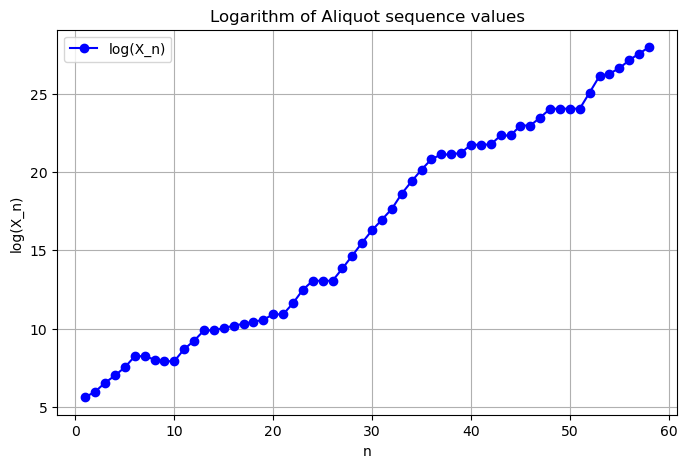

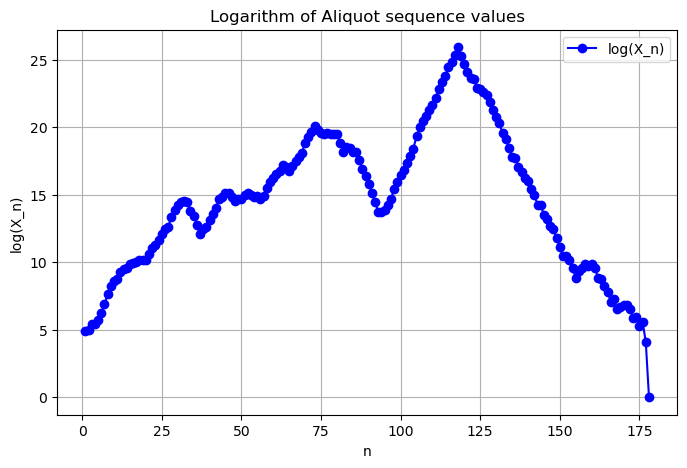

In [7]:
def plot_sequence(k: int):
    X = detect_aliquot_sequence_behaviour(k)[1]
    log_X = np.log(X)
    n = np.arange(1, len(X)+1)
    plt.figure(figsize=(8, 5))
    plt.plot(n, log_X, marker='o', linestyle='-', color='b', label='log(X_n)')
    plt.xlabel('n')
    plt.ylabel('log(X_n)')
    plt.title('Logarithm of Aliquot sequence values')
    plt.legend()
    plt.grid()
    plt.show()
plot_sequence(276)
plot_sequence(138)

***
## Question 4
This question was done with two methods. The aim was to defifne the sequence behaviour for all numbers less than 20000. We decided to store this data as a .json for easy reuse later. The first method involved redefining S and detect_aliquot_sequence_behaviour to be used with the concurrents.future library for multithreading. This required functions which share no data with each other - our previous functions using the caches would be of no use. The performance gains from concurrents.future were insufficient to offset those lost by the return to functions without global variables:
>(note that a peculiarity of multithreading in a notebook is the fact that all functions have to be imported from a separate file so please ensure multithreaded_dependencies.py is in the same folder as this notebook)

In [8]:


import json
import os
from concurrent.futures import ProcessPoolExecutor, TimeoutError
import concurrent
from multithreaded_dependencies import detect_aliquot_sequence_behaviour_for_multithreading
def S_for_multithreading_fake(n): # due to the use of a jupyter notebook I had to import these functions; i couldn't just declare them here
    if n == 0: 
        return 0 # the code is identical to S_for_multithreading(n) (contained in multithreading_dependencies.py)
    if n < 0:
        return 0
    else:

        return sum(i for i in range(1, n // 2 + 1) if n % i == 0) # multithreading requires function to affect no global variables





def detect_aliquot_sequence_behaviour_for_multithreading_fake(n): # likewise^^
    sequence = [n]
    visited = set()

    current = n 
    i = 0
    while current != 0:
        if i > 20:
            return "probably non terminating", sequence # if a sequence has more than 20 terms for performance's sake we declare it as non terminating
        if current in visited:
            # Loop detected
            loop_start_index = sequence.index(current)
            loop = sequence[loop_start_index:]
            return "Loop Detected", loop #If we detect a loop, we return string "Loop Detected" and the sequence
        visited.add(current)
        sequence.append(current)
        current = S_for_multithreading(current)
        i += 1
    # If we reach 0, it means the sequence terminates without a loop
    return "Terminates", sequence


def jsonbehaviourmaker(n: int, FILENAME: str):
    if __name__ == "__main__":
        behaviour_dict = {}
        # Create the executor with a limited number of cores.  
        with ProcessPoolExecutor(max_workers=os.cpu_count()) as executor: # I have ten cores you may have less and need to adjust accordingly. run corecheker.py to find out!
            futures = {
                executor.submit(detect_aliquot_sequence_behaviour_for_multithreading, i): i for i in range(1, n + 1)}
            total_tasks = len(futures)
            completed_tasks = 0
            for future in concurrent.futures.as_completed(futures):
                completed_tasks += 1
                i = futures[future]
                try:
                    behaviour_dict[i] = future.result(timeout=0.5)
                except TimeoutError:
                    behaviour_dict[i] = "probably non-terminating" # probably unneccessary but just in case it gets stuck on a sequence it will assume the sequence is non terminating. 
                except Exception as e:
                    behaviour_dict[i] = f"error: {e}"

                # Track progress
                print(f"Progress: {completed_tasks}/{total_tasks} ({(completed_tasks / total_tasks) * 100:.2f}%)")

        # Save results to a file
        file = FILENAME + ".json"
        with open(file, "w") as outfile:
            json.dump(behaviour_dict, outfile)
        print("successfully made " + file)

%timeit jsonbehaviourmaker(20000, "behaviour20000") # this could potentially thermal throttle your computer


Progress: 1/20000 (0.01%)
Progress: 2/20000 (0.01%)
Progress: 3/20000 (0.01%)
Progress: 4/20000 (0.02%)
Progress: 5/20000 (0.03%)
Progress: 6/20000 (0.03%)
Progress: 7/20000 (0.03%)
Progress: 8/20000 (0.04%)
Progress: 9/20000 (0.04%)
Progress: 10/20000 (0.05%)
Progress: 11/20000 (0.06%)
Progress: 12/20000 (0.06%)
Progress: 13/20000 (0.07%)
Progress: 14/20000 (0.07%)
Progress: 15/20000 (0.07%)
Progress: 16/20000 (0.08%)
Progress: 17/20000 (0.08%)
Progress: 18/20000 (0.09%)
Progress: 19/20000 (0.10%)
Progress: 20/20000 (0.10%)
Progress: 21/20000 (0.10%)
Progress: 22/20000 (0.11%)
Progress: 23/20000 (0.11%)
Progress: 24/20000 (0.12%)
Progress: 25/20000 (0.12%)
Progress: 26/20000 (0.13%)
Progress: 27/20000 (0.14%)
Progress: 28/20000 (0.14%)
Progress: 29/20000 (0.14%)
Progress: 30/20000 (0.15%)
Progress: 31/20000 (0.15%)
Progress: 32/20000 (0.16%)
Progress: 33/20000 (0.17%)
Progress: 34/20000 (0.17%)
Progress: 35/20000 (0.18%)
Progress: 36/20000 (0.18%)
Progress: 37/20000 (0.18%)
Progress: 

That function took us about 28.7 seconds. The following code defines the function far simpler using the behaviour detection function from question 3 and no more multithreading:

In [16]:

import gmpy2
import json
def gen_json_file(file_location, up_to):
    behaviours = {}
    print("Calculated up to:", end=" ")
    for i in range(1, up_to + 1):
        if (i%400) == 0:
            print(i, end=", ")
        behaviours[i] = detect_aliquot_sequence_behaviour(gmpy2.mpz(i))
        
    with open(file_location, "w") as file_obj:
        json.dump(behaviours, file_obj)
reset_caches()
def test():
    reset_caches()
    gen_json_file("test.json", 20000)
%timeit test()



Calculated up to: 400, 800, 1200, 1600, 2000, 2400, 2800, 3200, 3600, 4000, 4400, 4800, 5200, 5600, 6000, 6400, 6800, 7200, 7600, 8000, 8400, 8800, 9200, 9600, 10000, 10400, 10800, 11200, 11600, 12000, 12400, 12800, 13200, 13600, 14000, 14400, 14800, 15200, 15600, 16000, 16400, 16800, 17200, 17600, 18000, 18400, 18800, 19200, 19600, 20000, Calculated up to: 400, 800, 1200, 1600, 2000, 2400, 2800, 3200, 3600, 4000, 4400, 4800, 5200, 5600, 6000, 6400, 6800, 7200, 7600, 8000, 8400, 8800, 9200, 9600, 10000, 10400, 10800, 11200, 11600, 12000, 12400, 12800, 13200, 13600, 14000, 14400, 14800, 15200, 15600, 16000, 16400, 16800, 17200, 17600, 18000, 18400, 18800, 19200, 19600, 20000, Calculated up to: 400, 800, 1200, 1600, 2000, 2400, 2800, 3200, 3600, 4000, 4400, 4800, 5200, 5600, 6000, 6400, 6800, 7200, 7600, 8000, 8400, 8800, 9200, 9600, 10000, 10400, 10800, 11200, 11600, 12000, 12400, 12800, 13200, 13600, 14000, 14400, 14800, 15200, 15600, 16000, 16400, 16800, 17200, 17600, 18000, 18400, 18

As shown, this function is considerably quicker (we got 13.2 seconds). Please:
* Run the following cell.
* Search for behaviour20000.json in your file system and move it to be in the same folder as the jupyter notebook.

This is necessary for later functions which rely on behaviour20000.json

In [17]:
if "y" in input("Do you want to make 20_000 json? (y/n) ").lower():
    gen_json_file("behaviour20000.json", 20_000)
else:
    print("Ok")

Calculated up to: 400, 800, 1200, 1600, 2000, 2400, 2800, 3200, 3600, 4000, 4400, 4800, 5200, 5600, 6000, 6400, 6800, 7200, 7600, 8000, 8400, 8800, 9200, 9600, 10000, 10400, 10800, 11200, 11600, 12000, 12400, 12800, 13200, 13600, 14000, 14400, 14800, 15200, 15600, 16000, 16400, 16800, 17200, 17600, 18000, 18400, 18800, 19200, 19600, 20000, 

***
## Extension 1 (core)
The following function reads from our json file to print the max loop length in the first 20,000 numbers, along with the loop itself;

In [26]:
with open('behaviour20000.json', 'r') as file: # use the json file from above as our data for finding the largest Loop.
    data = json.load(file)

from itertools import islice
def max_loop_length(n: int):
    loop_lengths = [] # array with the lengths of loops
    loop_lengths_dict = {} # dictionary with loop lengths as the key and the loops themselves as the value (this is a one to many map as many loops share loop lengths)
    for key, value in islice(data.items(), n):
        if value[0] == "Loop Detected":
            loop_lengths.append(len(value[1]))
            loop_lengths_dict[len(value[1])] = value[1]
    print(loop_lengths_dict)
    return max(loop_lengths), loop_lengths_dict[max(loop_lengths)]
print(max_loop_length(20000))


{1: [6], 2: [2924, 2620], 28: [19916, 17716, 14316, 19116, 31704, 47616, 83328, 177792, 295488, 629072, 589786, 294896, 358336, 418904, 366556, 274924, 275444, 243760, 376736, 381028, 285778, 152990, 122410, 97946, 48976, 45946, 22976, 22744], 5: [12496, 14288, 15472, 14536, 14264]}
(28, [19916, 17716, 14316, 19116, 31704, 47616, 83328, 177792, 295488, 629072, 589786, 294896, 358336, 418904, 366556, 274924, 275444, 243760, 376736, 381028, 285778, 152990, 122410, 97946, 48976, 45946, 22976, 22744])


mpz(17716)

It appears there are only 4 different lengths of cycles less than 20,000: 1, 2, 5, and 28. The Online Encyclopaedia of Integer Sequences lists the length of loops in A052470. The vast majority are of length four and the loop containing 19916 is the only loop of length (28) greater than ten.

***
## Extension2 (core)
Here we plot a graph of n vs the length of the sequence containing n:

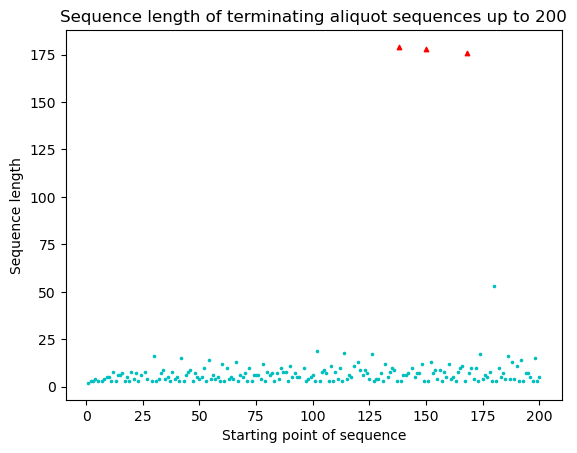

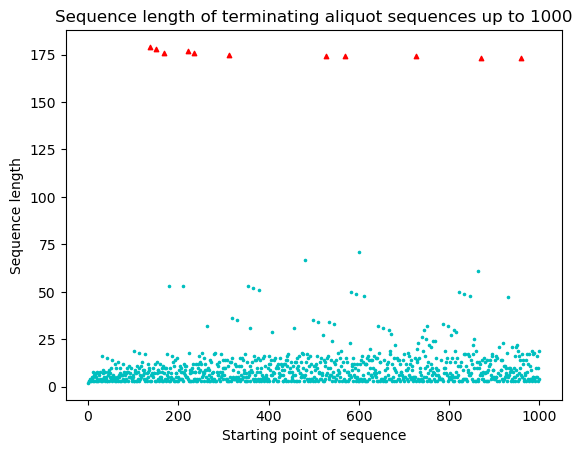

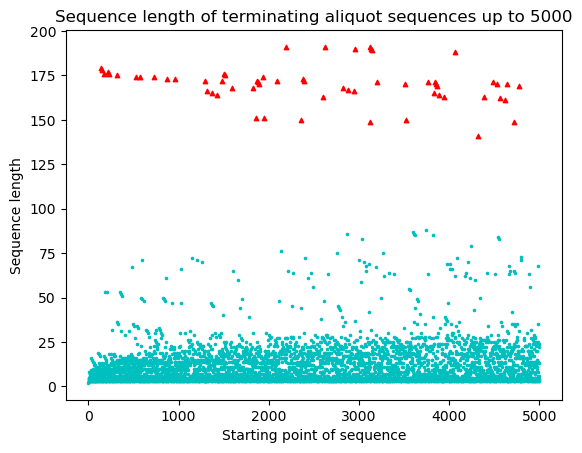

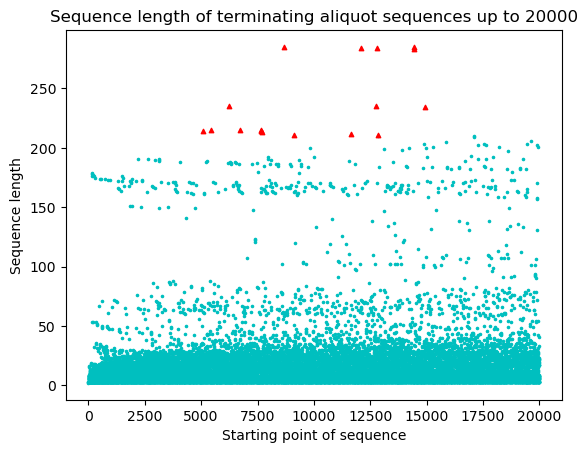

In [31]:
import numpy as np
import matplotlib.pyplot as plt
x_vals20000 = []
y_vals20000 = []
#From file version
with open("behaviour20000.json", "r") as file_obj:
    behaviours = json.load(file_obj)
    
for entry in behaviours:
    if behaviours[entry][0] == "Terminates":
        x_vals20000.append(int(entry))
        y_vals20000.append(len(behaviours[entry][1]) + 1)
        
x_vals20000 = np.array(x_vals20000)
y_vals20000 = np.array(y_vals20000)

points = np.array([x_vals20000, y_vals20000]).transpose()

#Helper function for plotting terminating aliquot sequences
#up_to tells when to stop considering the sequence
#mark_above tells when values above those should be marked
def plot_terminating_aliquot_seq(up_to, mark_above, marker_size=10, title=""):
    plt.figure()
    
    #Set to default title if title is blank
    if title == "":
        title = f"Sequence length of terminating aliquot sequences up to {up_to}"
    

    
    normal_points = np.array([i for i in points if 
                               (i[1] <= mark_above) and (i[0] <= up_to)])
    
    outlier_points = np.array([i for i in points if 
                               (i[1] > mark_above) and (i[0] <= up_to)])
    
    
    x_norm, y_norm = normal_points.transpose()
    x_out, y_out = outlier_points.transpose()
    
    #plotting the points
    plt.scatter(np.array(x_norm), np.array(y_norm), marker_size, "c", ".")
    plt.scatter(np.array(x_out), np.array(y_out), marker_size, "r", "^")
    plt.ylabel("Sequence length")
    plt.xlabel("Starting point of sequence")
    plt.title(title)
    
    
    plt.show()
    

"""
Question 2: Length of terminating sequence

After calculating all the terminating sequences that we could below 20,000
it seems that there is no limit to sequence length. As starting point of
sequences increase, so do the number of outliers with much higher sequence lengths.

Red triangles mark 
"""
plot_terminating_aliquot_seq(200, 80)
plot_terminating_aliquot_seq(1000, 100)
plot_terminating_aliquot_seq(5000, 120)
plot_terminating_aliquot_seq(20000, 210)


WRITE SOMEtHING CLEVER HERE

***
## Extension 3
In order to plot aliquot Sequences which enter loops it is useful to plot a graph  

In [ ]:
"""
EXTENSION3
"""

import networkx as nx
import pygraphviz
import matplotlib.pyplot as plt
# This plots the graph of aliquot sequences up to 300; whilst lower numbers can be used (the graph can get a bit crowded), i wanted to include the amicable pair {220, 284} 
onlyprimes = []
prime_dict = {}
SOE(10000)
def f(n):
    if n == 0:
        return None  # 0 is the end of the tree
    if n != 0:
        return S(n)

# Generate the tree
def generate_tree(max_n):
    tree = nx.DiGraph()
    for n in range(max_n + 1):
        result = f(n)
        if result is not None:
            tree.add_edge(n, result)
    return tree

# Visualize the tree
def visualize_tree(tree):
    pos = nx.nx_agraph.graphviz_layout(tree, prog="dot")
    plt.figure(figsize=(12, 8))
    nx.draw(tree, pos, with_labels=True, arrows=True, node_size=120, node_color="lightblue", font_size=4)
    plt.title("Tree Diagram of the Function")
    plt.show()

# Usage
max_n = 300 # Set the maximum number to explore
tree = generate_tree(max_n)
visualize_tree(tree)

In [ ]:
"""
EXTENSION4
"""


# answer to Related to perfect numbers are ‘abundant’ numbers with s(n) > n and ‘deficient’ numbers,
#where s(n) < n. A looping aliquot sequence should contain some of each. Compare the
#number of each up to a fixed value n.

import numpy as np
import matplotlib.pyplot as plt
SOE(20000)

def abundant_deficient(n: int):


    abundant = []
    deficient = []
    a = 0
    d = 0

    for i in range(1, n + 1):
        if S(i) > i:
            a += 1
        if S(i) < i:
            d += 1
        abundant.append(a)
        deficient.append(d)

    return abundant, deficient

def plot_abundant_deficient(n):
    
    abundant, deficient = abundant_deficient(n)

    n_values = np.arange(1, n)
    plt.figure(figsize=(10, 7))
    plt.plot(n_values, abundant[1:], label="Abundant", color="blue")
    plt.plot(n_values, deficient[1:], label="Deficient", color="red")

    plt.text(n, abundant[n - 1], f'{abundant[n - 1]}', color="blue", fontsize=12, ha='left', va='bottom')
    plt.text(n, deficient[n - 1], f'{deficient[n - 1]}', color="red", fontsize=12, ha='left', va='bottom')
    plt.xlim(0, n + 2000)

    plt.title("Total numbers of abundant and deficient numbers up to n")
    plt.xlabel("n")
    plt.ylabel("Total")
    plt.legend()
    plt.show()
plot_abundant_deficient(20000)